In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import requests, time, pickle
from bs4 import BeautifulSoup as soup
from IPython.core.display import display, HTML
def html(h):
    display(HTML(h))

In [2]:
plt.rcParams.update({'font.size': 20})


# NOTICE: Need to change the values for the variable your_header here
Here is where you can copy the Headers: [The Screenshot](screenshot.png)

And a warning: although this is a polit crawler, it may still cause Google Scholar to be cautious about your IP address.

In [3]:
# Build a fake header
# b is copied from Firefox->F12->Network->Headers
# the key Request Headers 740 B should change accordingly
headers = {}
# NOTICE: here is the tricky part:
# 1) Open a Firefox Private Window,
# 2) Press F12, go to the Network tab,
# 3) Go to scholar.google.com,
# 4) Copy All Headers and Paste the headers below, giving the value to the variable your_header:
your_header = {"Response Headers (543 B)":{"headers":[{"name":"alt-svc","value":"h3-27=\":443\"; ma=2592000,h3-25=\":443\"; ma=2592000,h3-Q050=\":443\"; ma=2592000,h3-Q049=\":443\"; ma=2592000,h3-Q048=\":443\"; ma=2592000,h3-Q046=\":443\"; ma=2592000,h3-Q043=\":443\"; ma=2592000,quic=\":443\"; ma=2592000; v=\"46,43\""},{"name":"cache-control","value":"private, max-age=0"},{"name":"content-encoding","value":"gzip"},{"name":"content-type","value":"text/html; charset=UTF-8"},{"name":"date","value":"Mon, 11 May 2020 14:47:50 GMT"},{"name":"expires","value":"Mon, 11 May 2020 14:47:50 GMT"},{"name":"server","value":"scholar"},{"name":"x-content-type-options","value":"nosniff"},{"name":"X-Firefox-Spdy","value":"h2"},{"name":"x-frame-options","value":"SAMEORIGIN"},{"name":"x-xss-protection","value":"0"}]},"Request Headers (699 B)":{"headers":[{"name":"Accept","value":"text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"},{"name":"Accept-Encoding","value":"gzip, deflate, br"},{"name":"Accept-Language","value":"en-US,en;q=0.5"},{"name":"Cache-Control","value":"max-age=0"},{"name":"Connection","value":"keep-alive"},{"name":"Cookie","value":"1P_JAR=2020-05-11-14; NID=204=x_pazZLcZzIcf7Mgstvc3gMkvlqwlq0bx67Idc0qnbLVOzTf1cicKHmBr2hsMvFxUjnng7j2ewfqfvuPHZMSxu55-ero5h8bGcJ1boiZF7E9DoeUXwSRUTIGD5jF4rJk5LYawTx3Dvugb9JjbHKYu2d3F51ybPQZV8lOz7lbtEU; GSP=LM=1589208463:S=kJAM9K07dK4mvJoE"},{"name":"DNT","value":"1"},{"name":"Host","value":"scholar.google.com"},{"name":"Referer","value":"https://scholar.google.com/"},{"name":"TE","value":"Trailers"},{"name":"Upgrade-Insecure-Requests","value":"1"},{"name":"User-Agent","value":"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:76.0) Gecko/20100101 Firefox/76.0"}]}}
# 5) Then run the rest of the code.

key = list(your_header.keys())[1] # should be something like: 'Request Headers (740 B)'
print(key)
request_header = your_header[key]['headers']
l = len(request_header)
for i in range(l):
    headers[request_header[i]['name']] = request_header[i]['value']


Request Headers (699 B)


In [4]:
cache = None
def scrape_scholar(terminology, year, force=False):
    """
    terminology is a word or phrase, such as 'genetic algorithms',
    year is an integer, such as 2002.
    return the html of google scholar.
    
    need writing permission on the disk to cache the response of google scholar to reduce the number of requests.
    note: scrape the page from google scholar is not allowed in ToS.
    """
    global cache
    
    import os, pickle
    if cache is None:
        if os.path.exists("google.scholar.cache.pickle"):
            with open("google.scholar.cache.pickle", "rb") as f:
                cache = pickle.load(f)
        else:
            cache = {}

    url = f"https://scholar.google.com/scholar?q={terminology}&hl=en&as_sdt=0%2C46&as_ylo={year}&as_yhi={year}"
    response = None
    if url in cache and not force:
        if cache[url].find("Our systems have detected unusual traffic from your computer")==-1:
            response = cache[url]
    
    if response is None:
        response = requests.get(url, headers=headers).text
        time.sleep(2)
        print(f".", end='', flush=True)
        # cache good response
        if response.find("Our systems have detected unusual traffic from your computer")==-1:
            cache[url] = response
            with open("google.scholar.cache.pickle", "wb") as f:
                pickle.dump(cache, f)

    return cache[url]

In [5]:
def get_count(text):
    """
    text is the html that contains the counts
    return an integer which is the count
    """
    import re
    count = 0
    try:
        m = re.findall('About ([0-9,]*) results', text)
        count = int(m[0].replace(',',''))
    except:
        count = 0
    return count

In [6]:
def plot_terms(terms, force=False):
    """
    terms is a list of terminologies, such as ['evolutionary robotics', 'genetic algorithms']
    no return.
    """
    plt.figure(figsize=[15,5])
    counts = {}
    max_count = 0
    for term in terms:
        start_year = 2000
        end_year = 2020
        counts[term] = []
        years = list(range(start_year, end_year, 1))
        for year in years:
            html = scrape_scholar(term, year, force)
            c = get_count(html)
            counts[term].append(c)
        plt.plot(years, counts[term], label=term)
        if int(max(counts[term])/1000)>max_count:
            max_count = int(max(counts[term])/1000)
    plt.legend()
    num_ticks = list(range(0,max_count+1,int(max_count/10)+1))
    num_ticks = [c*1000 for c in num_ticks]
    str_ticks = [str(int(c/1000))+'k' for c in num_ticks]
    plt.yticks(num_ticks, str_ticks)
    plt.xticks(years, rotation=45)
    plt.title("The Number of Results in Google Scholar over 20 years")
    plt.ylabel("Number of Results")
    plt.tight_layout()
    plt.savefig("plot.jpg")
    plt.show()

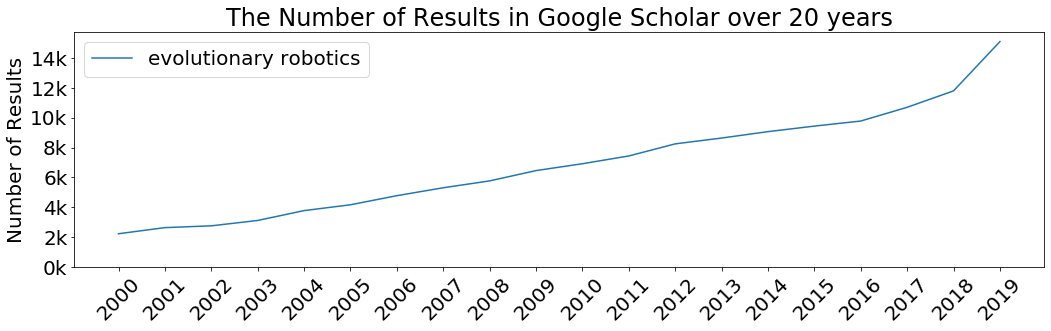

In [7]:
plot_terms(["evolutionary robotics"])

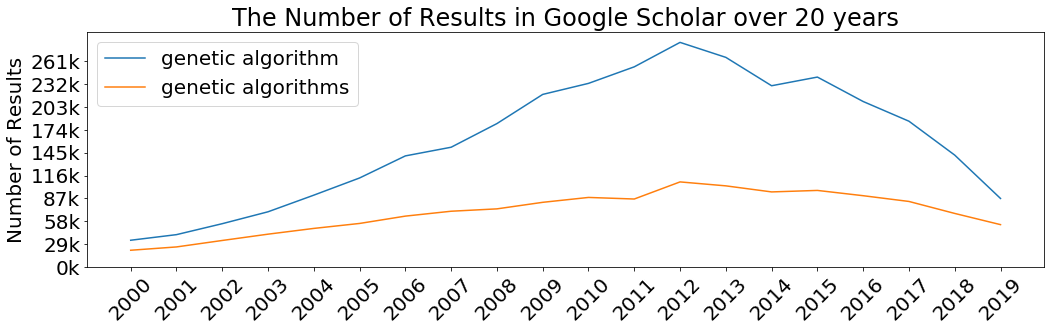

In [8]:
plot_terms(["genetic algorithm", "genetic algorithms"])

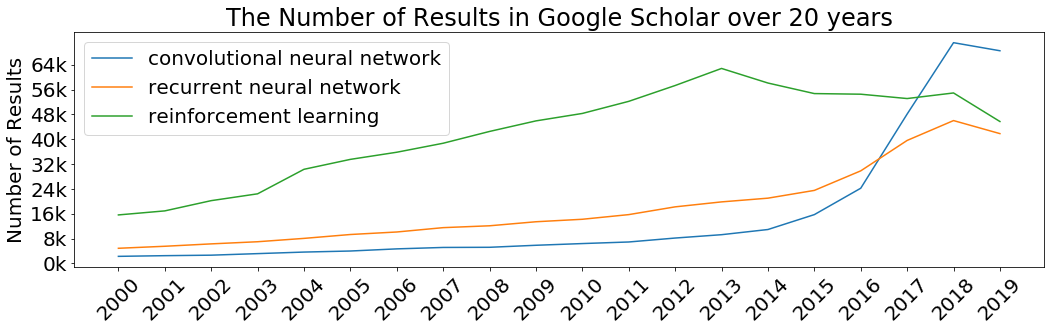

In [9]:
plot_terms(["convolutional neural network", "recurrent neural network", "reinforcement learning"])

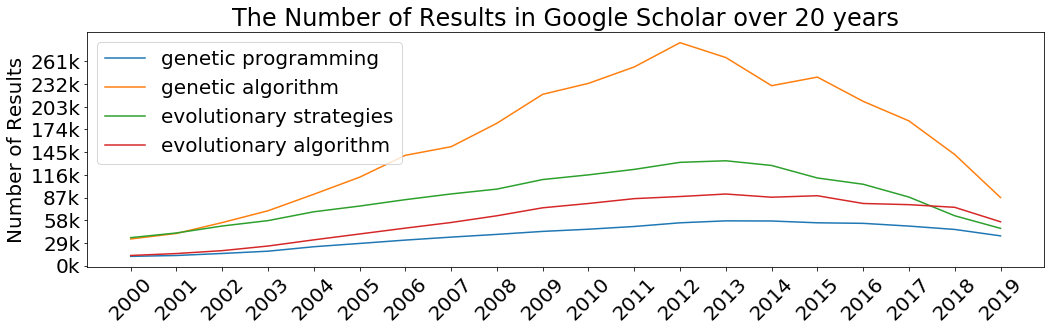

In [10]:
plot_terms(["genetic programming", "genetic algorithm", "evolutionary strategies", "evolutionary algorithm"])

....................

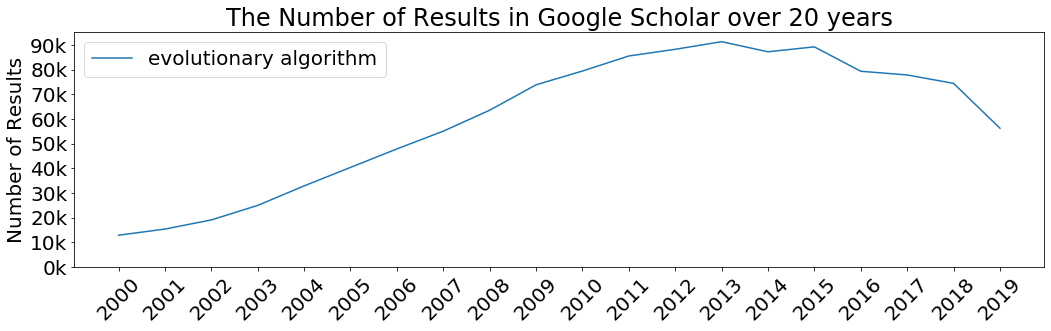

In [11]:
# add a force=True if you want to force the program to fetch data from server, instead of using cache.
plot_terms(["evolutionary algorithm"], force=True)